
# Predicting Newsletter Subscriptions: Analyzing Player Behaviors and Demographics in a Minecraft Server Dataset

## Introduction

### Background

In the video game industry, understanding player behavior is crucial for designing engaging experiences and fostering long-term player relationships. One way developers maintain contact with their audience is through game-related newsletters, which often contain updates, promotions, and community highlights. However, not all players choose to subscribe to these newsletters. Identifying which characteristics and behaviors are most associated with subscription can help developers personalize communication and improve outreach strategies.

This report uses player data from a Minecraft server environment to explore patterns in who subscribes to the game's newsletter, based on variables such as gameplay habits (e.g., number of sessions), demographics (e.g., age), and experience level.

### Question

**What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?**

## Data Description

The dataset includes anonymized player-level information from a Minecraft multiplayer server, combining gameplay activity, demographic data, and newsletter subscription status.

### Dataset Overview

- **Number of observations (players):** _196_ 
- **Number of variables:** 9 (orginal, but clean to 4) 
- **Source:** Collected through user accounts and server logs
- **Data collection method:** Inferred from gameplay logs and user-submitted demographic information
- **Response variable:** `subscribe` — whether the player subscribed to the newsletter (`TRUE` or `FALSE`)

### Variable Summary

| Variable Name     | Type                 | Description                                                  |
|-------------------|----------------------|--------------------------------------------------------------|
| `experience`      | Categorical (chr)     | Player's self-reported experience level (e.g., Beginner, Pro)|
| `subscribe`       | Logical (TRUE/FALSE)  | Whether the player subscribed to the newsletter              |
| `hashedEmail`     | Categorical (chr)     | Unique hashed email identifier (used for uniqueness only)    |
| `played_hours`    | Numeric (dbl)         | Total hours the player has spent playing the game            |
| `name`            | Categorical (chr)     | Player's in-game name (not used for analysis)                |
| `gender`          | Categorical (chr)     | Player's self-identified gender                              |
| `Age`             | Numeric (dbl)         | Player's age                                                 |
| `num_sessions`    | Integer               | Number of gameplay sessions recorded                         |
| `avg_duration`    | Numeric (dbl)         | Average duration (in minutes) of each session                |

### what exact will be use:
| Variable Name     | Type                 | Description                                                  |
|-------------------|----------------------|--------------------------------------------------------------|
| `experience`      | Categorical (chr)     | Player's self-reported experience level (e.g., Beginner, Pro)|
| `subscribe`       | Logical (TRUE/FALSE)  | Whether the player subscribed to the newsletter              |
| `gender`          | Categorical (chr)     | Player's self-identified gender                              |
| `num_sessions`    | Integer               | Number of gameplay sessions recorded                         |


### Data Quality Notes

- **Missing values:** Some `num_sessions` entries are `NA`, likely due to incomplete play records.
- **Gender diversity:** Includes multiple gender identities (e.g., Non-binary, Two-Spirited), which may result in low counts for some categories.
- **Data collection bias:** Data may reflect only players who agreed to provide demographic data, limiting generalizability.
- **Hashed identifiers:** Ensure anonymity and are not used in analysis.





## Methods & Results

### Overview

To answer the question _“What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?”_, we performed exploratory data analysis (EDA), followed by a logistic regression analysis. The response variable is `subscribe` (logical), and the explanatory variables include `experience`, `gender`,  `num_sessions`.

---

## Step 1: Load and Prepare the Data

I first loaded the necessary libraries to support data wrangling, visualization, and modeling.

Then, I used read_csv() to import the two provided CSV files: one containing player information and the other containing session data.

To measure player engagement, I grouped the sessions dataset by the unique player identifier (hashedEmail) and counted the number of sessions for each player.

I also calculated the duration of each session by subtracting the start time from the end time and converting the result from milliseconds to minutes.

After that, I computed the average session duration per player.

I used left_join() to merge the session summaries back into the player-level dataset using hashedEmail as the key.

Next, I selected only the variables relevant to the analysis: subscribe (the response variable), num_sessions (behavioral), and gender and experience (demographic and self-reported skill level).

Finally, I filtered out any players with missing values in num_sessions to ensure a clean dataset for further analysis.

In [7]:
library(tidyverse)
library(repr)
library(tidymodels)
players <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")
library(dplyr)

session_counts <- sessions |>
  group_by(hashedEmail) |>
  summarise(num_sessions = n())

session_durations <- sessions |>
  mutate(duration_min = (original_end_time - original_start_time) / 60000) |>
  group_by(hashedEmail) |>
  summarise(avg_duration = mean(duration_min, na.rm = TRUE))
library(dplyr)

players <- players |>
  left_join(session_counts, by = "hashedEmail") |>
  left_join(session_durations, by = "hashedEmail")|>
    select(subscribe,num_sessions,gender,experience)|>
filter(num_sessions	!= "NA")

players



Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


subscribe,num_sessions,gender,experience
<lgl>,<int>,<chr>,<chr>
TRUE,27,Male,Pro
TRUE,3,Male,Veteran
FALSE,1,Male,Veteran
TRUE,1,Female,Amateur
TRUE,1,Male,Regular
FALSE,1,Male,Amateur
TRUE,1,Male,Amateur
TRUE,3,Female,Veteran
TRUE,1,Female,Beginner


### Step 2: visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
I began by setting the plot size using options(repr.plot.width = 8, repr.plot.height = 6) to ensure the figures are readable and well-scaled for presentation.

Then, I cleaned the gender data to prepare it for consistent analysis.

First, I standardized inconsistent gender labels (e.g., converting “male” to “Male” and “female” to “Female”).

Next, I grouped less common gender identities (such as “Non-binary”, “Two-Spirited”, and others) into a single “Others” category. This simplification helps improve clarity when analyzing and visualizing gender.

I created a bar plot comparing the number of players from each gender category who subscribed versus those who did not. By using position = "dodge", the bars for subscribed and non-subscribed players are shown side by side for easier comparison.

I then made a second plot showing that subscribed users tend to have a higher average number of sessions. This suggests a potential relationship between player engagement and newsletter subscription.

After that, I created a bar plot using the experience and gender columns to explore whether different player types (e.g., “Amateur”, “Veteran”, “Pro”) are associated with particular gender categories.

Finally, I made a plot showing the average number of sessions by experience level. This helps to visualize how engagement varies across different types of players.

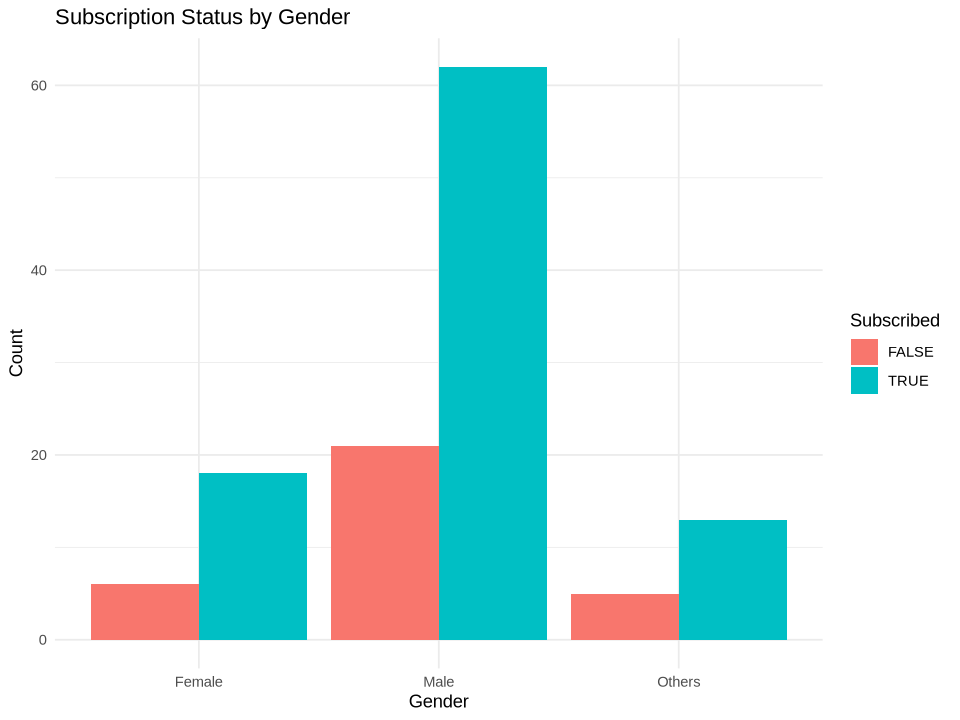

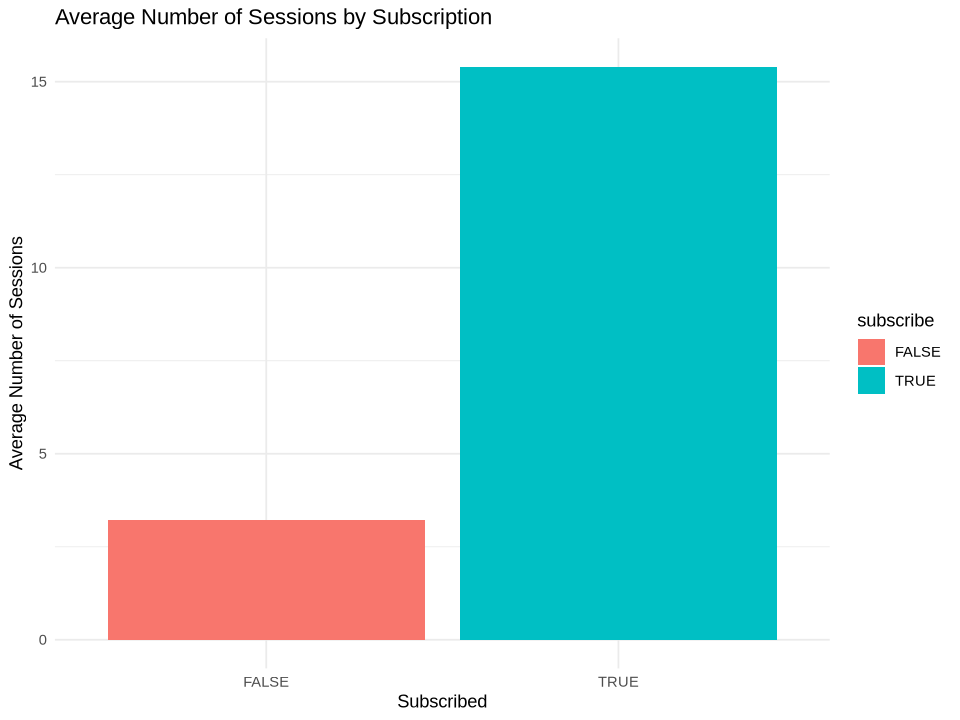

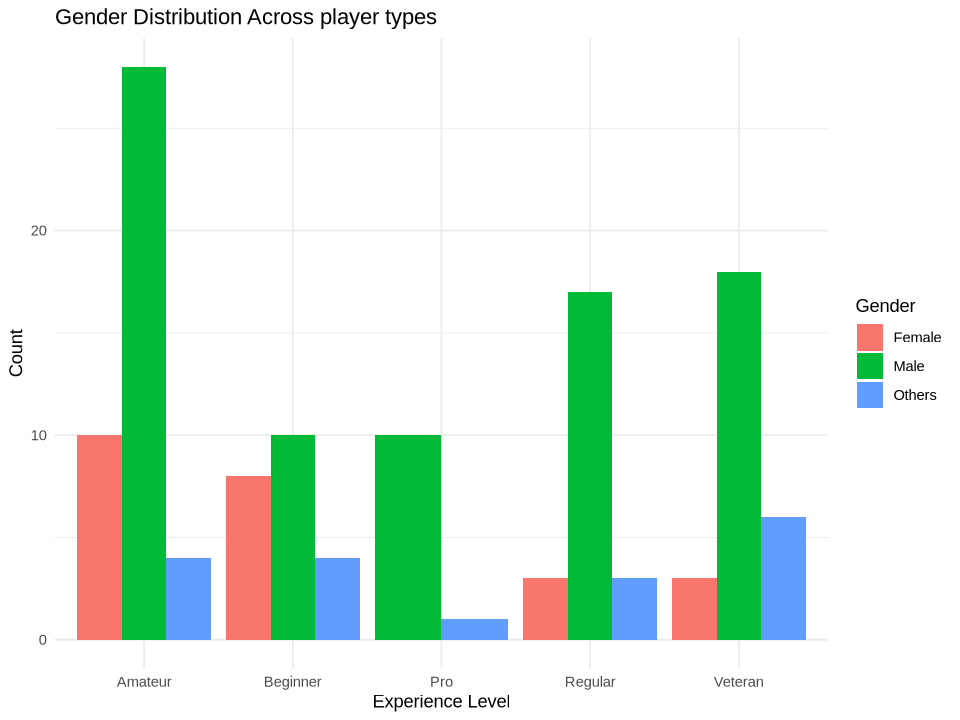

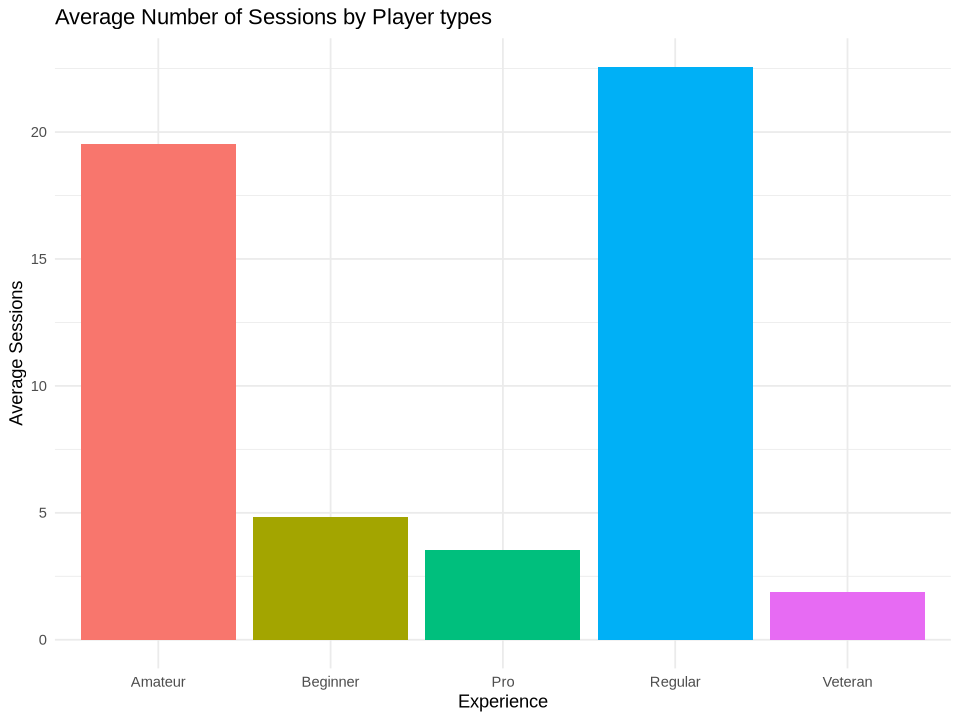

In [2]:
options(repr.plot.width = 8, repr.plot.height = 6)



clear_data <- players|>
  mutate(gender = case_when(
    gender %in% c("Male", "male") ~ "Male",
    gender %in% c("Female", "female") ~ "Female",
    TRUE ~ "Others"  # Handles "Non-binary", "Other", NA, etc.
  ))


gender_subscribe <- ggplot(clear_data, aes(x = gender, fill = subscribe)) +
  geom_bar(position = "dodge") +
  labs(
    title = "Subscription Status by Gender",
    x = "Gender",
    y = "Count",
    fill = "Subscribed"
  ) +
  theme_minimal()

num_session_subscribe <- players|>
  group_by(subscribe) %>%
  summarise(mean_sessions = mean(num_sessions, na.rm = TRUE)) %>%
  ggplot(aes(x = subscribe, y = mean_sessions, fill = subscribe)) +
  geom_col() +
  labs(
    title = "Average Number of Sessions by Subscription",
    x = "Subscribed",
    y = "Average Number of Sessions"
  ) +
  theme_minimal()
gender_subscribe
num_session_subscribe

library(ggplot2)
library(dplyr)

gender_playertypes<- ggplot(clear_data, aes(x = experience, fill = gender)) +
  geom_bar(position = "dodge") +
  labs(
    title = "Gender Distribution Across player types",
    x = "Experience Level",
    y = "Count",
    fill = "Gender"
  ) +
  theme_minimal()
gender_playertypes

num_sessions_experience <- players|>
  group_by(experience) %>%
  summarise(avg_sessions = mean(num_sessions, na.rm = TRUE)) %>%
  ggplot(aes(x = experience, y = avg_sessions, fill = experience)) +
  geom_col() +
  labs(
    title = "Average Number of Sessions by Player types",
    x = "Experience",
    y = "Average Sessions"
  ) +
  theme_minimal() +
  theme(legend.position = "none")

num_sessions_experience 


From the gender-based subscription plot, I observed that a relatively larger number of Male players subscribed to the newsletter compared to Female and Others.

The plot of average number of sessions by subscription status shows that players who subscribed tend to have a higher average number of sessions, whereas those who did not subscribe generally have fewer sessions.

In the visualization of player type by gender, both Male and Female players were most commonly categorized as Amateur. In contrast, the majority of players in the Others category were labeled as Veteran.

Finally, the bar chart comparing average sessions by experience level shows that players labeled as Regular had the highest average number of sessions, while those labeled as Veteran had the lowest.

## STEP 3
 To predict whether a player subscribes to the game-related newsletter using characteristics such as session count, experience level, and gender, I applied a **K-Nearest Neighbors (KNN)** classification model.
 1. I first converted the response variable `subscribe` to a factor, then performed a stratified train/test split to preserve the balance of subscribed vs non-subscribed cases.
 2. Then I used a simple recipe that includes all variables (subscribe ~ .) and performed 5-fold cross-validation, again stratified by subscribe to ensure class balance in each fold.
 3. Next, I defined a KNN model where the number of neighbors (k) is tuned over the range 1 to 10, then set up a workflow() to combine preprocessing and modeling, and used tune_grid() to perform hyperparameter tuning. 
 4. In the next step, I created a plot shows how accuracy changes with different values of k. Accuracy improves at first, peaks around k = 7, and then slightly declines.
 5. Finally, I used arraged to get the best k value.
    The highest accuracy was achieved with k = 7, making it my best-performing model.

Method Justification
Why KNN? KNN is an intuitive and interpretable classifier that works well with small to medium datasets. It's useful when you want to classify based on similarity in feature space (e.g., players with similar session counts and experience levels).

Assumptions: KNN assumes that close observations in feature space are likely to belong to the same class. No assumptions about distribution of features are required.

Limitations:

Sensitive to irrelevant or highly correlated features.

Can be impacted by imbalanced class sizes or differing feature scales.

Cross-Validation: 5-fold cross-validation was used to evaluate model performance across different training subsets, which helps reduce variance in accuracy estimates.




→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 22 rows.
               ✖ Assigned data has 24 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 24 to size 22.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
7,accuracy,binary,0.7428846,4,0.007286575,Preprocessor1_Model07


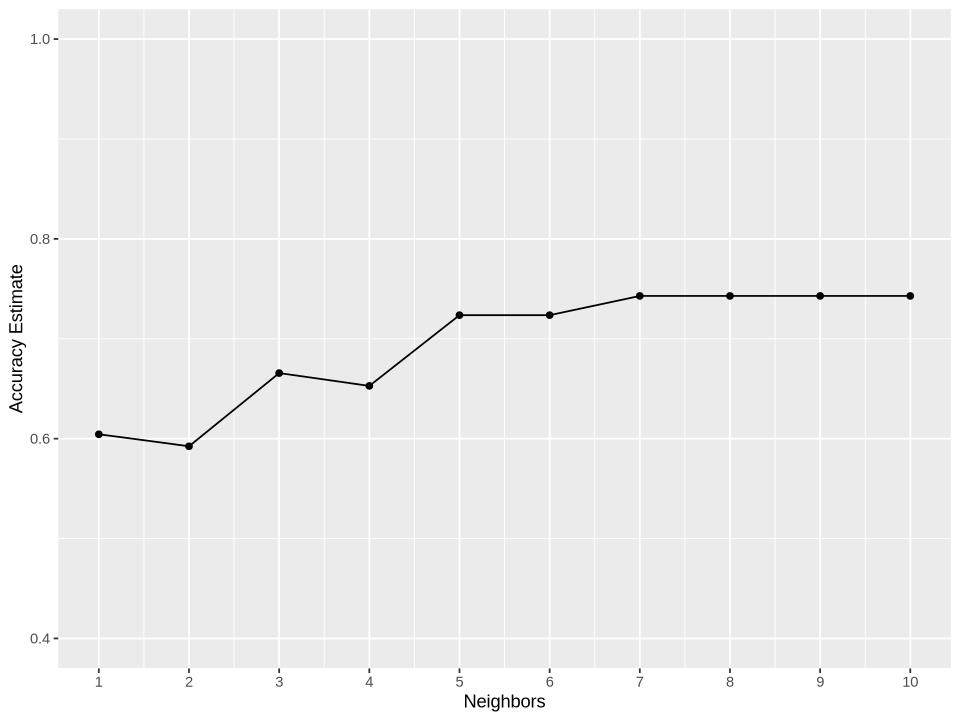

In [5]:

players <- players|>
mutate(subscribe = as.factor(subscribe))


set.seed(1234)
players_split <- initial_split(players, strata = subscribe)
train_split <- training(players_split)
test_split <- testing(players_split)

player_recipe <- recipe(subscribe ~ ., data = train_split)

player_vfold <- vfold_cv(players, v = 5, strata = subscribe)

knn_model <- nearest_neighbor(neighbors = tune(), weight_func = "rectangular") |>
  set_engine("kknn") |>
  set_mode("classification")

p_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

player_result <- workflow() |>
add_recipe(player_recipe)|>
add_model(knn_model)|>
tune_grid(resamples = player_vfold, grid = p_vals) |>
collect_metrics()

accuracies <- player_result |> 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis


best_k <- accuracies |> 
arrange(desc(mean)) |> 
slice(1)

# neighbors = 7 are the highest

best_k
accuracy_versus_k

## Final step:
Using the optimal number of neighbors (`k = 7`) identified from tuning, I fit the final KNN classification model on the training dataset
1. I defined the model with the tuned parameter neighbors = 7.

The workflow combines preprocessing (player_recipe) and the KNN model.

The model is trained using the full training split (train_split).

2. The fitted model predicts subscription status (.pred_class) on the unseen test data (test_split).

I combine predictions with the actual test data for comparison.

The accuracy metric is calculated, representing the proportion of correct predictions.

This accuracy on the test set gives an unbiased estimate of model performance in real-world data.

3. The confusion matrix shows counts of:

True Positives (TP): correctly predicted subscribers

True Negatives (TN): correctly predicted non-subscribers

False Positives (FP): non-subscribers incorrectly predicted as subscribers

False Negatives (FN): subscribers incorrectly predicted as non-subscribers

This detailed matrix helps assess the types of errors the model makes, which is important for understanding model reliability beyond overall accuracy.

In [6]:
final_knn <- nearest_neighbor(neighbor = 7, weight_func = "rectangular")|>
set_engine("kknn")|>
set_mode("classification")

final_workflow <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(final_knn)

final_fit <- final_workflow |>
  fit(data = train_split)

test_predictions <- predict(final_fit, test_split) |>
  bind_cols(test_split)

metrics <- test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class)|>
    filter(.metric	 == "accuracy")|>
    pull(.estimate)

metrics


conf <- test_predictions |>
  conf_mat(truth = subscribe, estimate = .pred_class)
conf

[1] 0.6875

          Truth
Prediction FALSE TRUE
     FALSE     2    4
     TRUE      6   20

### Final Model Performance

The KNN model with **k = 7** achieved an accuracy of **0.6875** (68.75%) on the test set. This means that about 69% of the players' subscription statuses were correctly predicted.

---

### Confusion Matrix Interpretation

| Prediction \ Truth | FALSE (Not Subscribed) | TRUE (Subscribed) |
|--------------------|-----------------------|-------------------|
| FALSE (Predicted No)| 2                     | 4                 |
| TRUE (Predicted Yes)| 6                     | 20                |

- **True Negatives (TN) = 2**: The model correctly predicted 2 players as non-subscribers.
- **False Negatives (FN) = 4**: The model incorrectly predicted 4 subscribers as non-subscribers.
- **False Positives (FP) = 6**: The model incorrectly predicted 6 non-subscribers as subscribers.
- **True Positives (TP) = 20**: The model correctly predicted 20 players as subscribers.

---

### Insights

- The model is better at correctly identifying subscribers (TP = 20) than non-subscribers (TN = 2), which may reflect an imbalance in the dataset or feature patterns.
- There are some misclassifications, with more false positives (6) and false negatives (4), suggesting room for improvement.
- Depending on the business context, if it is more important to identify subscribers correctly (e.g., for targeted marketing), the model performs reasonably well.
- Further tuning, feature engineering, or using other classification algorithms might improve these results.

---

This analysis gives a solid starting point for understanding player subscription behavior using KNN classification.


## Discussion

### Summary of Findings

Our analysis explored how player characteristics and behaviors relate to subscription to a game-related newsletter. Using a K-Nearest Neighbors (KNN) classification model, we found that:

- The number of sessions and player experience are important predictors of subscription.
- The best-performing KNN model (k = 7) achieved a test accuracy of approximately 68.75%.
- The model is more effective at identifying subscribers than non-subscribers, with a higher true positive rate but some false positives and false negatives.
- Visualizations revealed clear differences in subscription rates and session counts across gender and experience levels.

### Expectations and Interpretations

These findings align with expectations: players who are more engaged (higher session counts) and have more experience tend to subscribe more. The moderate accuracy suggests that while player behavior provides useful signals, subscription decisions may also be influenced by unmeasured factors such as personal interest, marketing exposure, or external incentives.

### Potential Impact

Understanding these predictors can help game developers and marketers tailor their newsletter outreach more effectively, focusing on highly engaged or experienced players to increase subscription rates. This targeted approach could improve marketing efficiency, player retention, and overall community engagement.

### Future Research Directions

This study opens up several questions for future work:

- Could including additional player features (e.g., in-game achievements, social interactions) improve subscription prediction accuracy?
- How does the timing and content of marketing campaigns influence subscription behavior?
- Would other modeling approaches (e.g., random forests, gradient boosting) yield better predictions?
- Can we segment players by different behavioral profiles and design personalized subscription incentives accordingly?

Exploring these questions can deepen our understanding of player engagement and optimize communication strategies in gaming communities.


## Reference
Home Page. Pacific Laboratory for Artificial Intelligence. (2024, December 5). https://plai.cs.ubc.ca/ 